# This is the Deep Learning solution transformer fase of the project!
### First we intalled tf-keras because of some version issues. 

In [3]:
pip install tf-keras

In [ ]:
pip install accelerate torch transformers

### Here we set the environments. 

In [2]:
import pandas as pd
import tensorflow as tf
from transformers import pipeline
import re
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import EarlyStoppingCallback

### Loading the dataset. 

In [5]:
df = pd.read_csv("data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

### First, let's start with the tokenization of the data to remove special characters.

In [8]:
def clean_and_tokenize(text):
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = text.lower()
        tokens = text.split()
        return " ".join(tokens)
    return ""

df["cleaned_reviews"] = df["reviews.text"].apply(clean_and_tokenize)

print(df[["reviews.text", "cleaned_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                     cleaned_reviews  
0  i thought it would be as big as small paper bu...  
1  this kindle is light and easy to use especiall...  
2  didnt know how much id use a kindle so went fo...  
3  i am happy with my purchase i caught it on sal...  
4  solid entry level kindle great for kids gifted...  


### Then we work on applying the tokenization using the tokenizer with the HuggingFace Transformers. 
### The text data is converted into input tokens suitable for model input. 

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.encode(text, truncation=True, padding="max_length", max_length=128)
    return []

df["tokenized_reviews"] = df["reviews.text"].apply(tokenize_text)

df.to_csv("tokenized_reviews.csv", index=False)
print(df[["reviews.text", "tokenized_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                   tokenized_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### After that, we encode the tokenize input sequences into numerical IDs using the tokenizer's vocabulary.

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def encode_text(text):
    if isinstance(text, str):
        tokens = tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return tokens["input_ids"].squeeze().tolist()  # Convert tensor to list
    return []

df["encoded_reviews"] = df["reviews.text"].apply(encode_text)

df.to_csv("encoded_reviews.csv", index=False)
print(df[["reviews.text", "encoded_reviews"]].head())

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                     encoded_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### Finally, we inplement the sentiment into the data set with it's calculations. 

In [21]:
df.to_csv("Transformer_Sentiment_Results.csv")

In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Function to tokenize text using the DistilBERT tokenizer
def tokenize_text(text):
    if isinstance(text, str):
        return tokenizer.encode(text, truncation=True, padding="max_length", max_length=128)
    return []

# Apply tokenization to the review text column
df["tokenized_reviews"] = df["reviews.text"].apply(tokenize_text)

# Save and inspect the results
df.to_csv("tokenized_reviews.csv", index=False)  # Save tokenized data
print(df[["reviews.text", "tokenized_reviews"]].head())  # Print first few rows for verification

                                        reviews.text  \
0  I thought it would be as big as small paper bu...   
1  This kindle is light and easy to use especiall...   
2  Didnt know how much i'd use a kindle so went f...   
3  I am 100 happy with my purchase. I caught it o...   
4  Solid entry level Kindle. Great for kids. Gift...   

                                   tokenized_reviews  
0  [101, 1045, 2245, 2009, 2052, 2022, 2004, 2502...  
1  [101, 2023, 2785, 2571, 2003, 2422, 1998, 3733...  
2  [101, 2134, 2102, 2113, 2129, 2172, 1045, 1005...  
3  [101, 1045, 2572, 2531, 3407, 2007, 2026, 5309...  
4  [101, 5024, 4443, 2504, 2785, 2571, 1012, 2307...  


### trianing model

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

df = df[['reviews.text', 'reviews.rating']].dropna()

df['label'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['reviews.text'], df['label'], test_size=0.2, random_state=42
)

train_data = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
test_data = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    num_train_epochs=1, 
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    warmup_ratio=0.1, 
    lr_scheduler_type="linear", 
    fp16=True, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer
)

from transformers import EarlyStoppingCallback
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=2, 
    early_stopping_threshold=0.01
))

trainer.train()

model.save_pretrained("fine_tuned_bert")
tokenizer.save_pretrained("fine_tuned_bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

2025/01/31 01:09:31 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch,Training Loss,Validation Loss
1,0.180700,0.133319


('fine_tuned_bert\\tokenizer_config.json',
 'fine_tuned_bert\\special_tokens_map.json',
 'fine_tuned_bert\\vocab.txt',
 'fine_tuned_bert\\added_tokens.json',
 'fine_tuned_bert\\tokenizer.json')

### Acuracy and losses and model.

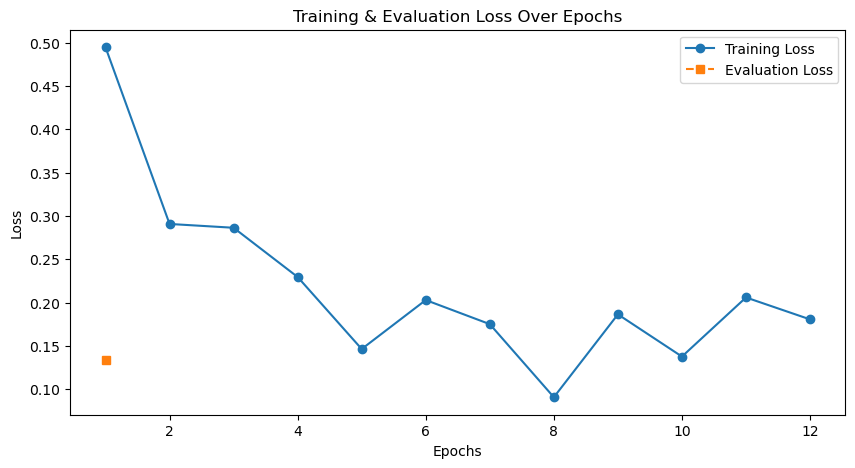

No evaluation accuracy logged. Ensure `compute_metrics` is enabled in Trainer.


In [28]:
import matplotlib.pyplot as plt
import numpy as np


if "trainer" in globals() and hasattr(trainer, "state"):
    train_logs = trainer.state.log_history

    train_loss = [log["loss"] for log in train_logs if "loss" in log]
    eval_loss = [log["eval_loss"] for log in train_logs if "eval_loss" in log]
    eval_accuracy = [log["eval_accuracy"] for log in train_logs if "eval_accuracy" in log]

    epochs = np.arange(1, len(train_loss) + 1)


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Training Loss", marker="o")
    if eval_loss:
        plt.plot(epochs[:len(eval_loss)], eval_loss, label="Evaluation Loss", marker="s", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Evaluation Loss Over Epochs")
    plt.legend()
    plt.show()


    if eval_accuracy:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label="Evaluation Accuracy", marker="d", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Evaluation Accuracy Over Epochs")
        plt.legend()
        plt.show()
    else:
        print("No evaluation accuracy logged. Ensure `compute_metrics` is enabled in Trainer.")
else:
    print("Trainer not found. Run `trainer.train()` first before plotting.")